<a href="https://colab.research.google.com/github/Suyoung-Min/Pytorch-Tutorial/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

In [3]:
print('Using PyTorch version:', torch.__version__, 'Device: ',DEVICE)

Using PyTorch version: 1.9.0+cu111 Device:  cuda


In [4]:
BATCH_SIZE = 32
EPOCH = 10

train_dataset = datasets.MNIST(root = '../data//MNIST',
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = '../data/MNIST',
                              train = False,
                              transform = transforms.ToTensor())
 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data//MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data//MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data//MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data//MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data//MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data//MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data//MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data//MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [10]:
for(X_train, y_train) in train_loader:
  print('X_train:',X_train.size(),'type:',X_train.type())
  print('y_train:',y_train.size(),'type:',y_train.type())
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


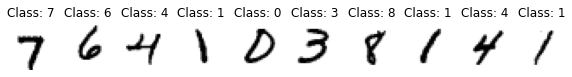

In [14]:
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28),cmap = 'gray_r')
  plt.title('Class: ' + str(y_train[i].item()))

In [16]:
#MLP model 설계

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
  def forward(self, x):
    x = x.view( -1, 28*28)
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

In [18]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [26]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image,label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output,label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
              loss.item()))

In [21]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label =label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [27]:
for Epoch in range(1, EPOCH + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy: {:.2f} %\n'.
        format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.305315
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.288196
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.343108
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.324332
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.311352
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.269556
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.283650
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.229955
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.231792
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.151756

[EPOCH : 1], 	Test Loss : 0.0696, 	Test Accuracy: 15.84 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 2.193467
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.163325
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.153060
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.121065
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 1.931305
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 1.865610
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 1.793001
Train Epoch: 2 [4